Analytic calculation of reconstructed kappa noise and delensing efficiency

In [1]:
import numpy as np, basic, prjlib, quad_func, plottools as pl, lens_tools
from matplotlib.pyplot import *

In [2]:
p, f, r = prjlib.analysis_init(t='la',freq='coadd',rlmin=500,rlmax=3000,dlmin=20,dlmax=2048,lTmin=500,lTmax=3000,exttag='_iso_ana')
__, fco, __ = prjlib.analysis_init(t='co',freq='coadd')
ep = 1e-60

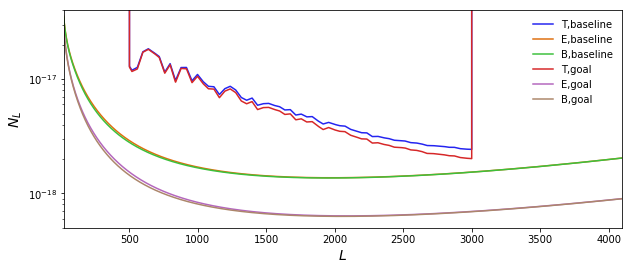

In [3]:
pl.plot_1dstyle(fsize=[10,4],xmin=20,xmax=4096,ylog=True,ymin=5e-19,ymax=4e-17,ylab='$N_L$')
Nl = {}
for ntype in ['baseline','goal']:
    Nl[ntype] = prjlib.nlofficial(dimless=True,ntype=ntype,lTmin=p.lTmin,lTmax=p.lTmax,deproj=0,lmax=p.lmax,cols=(3,4,5,6))
    plot(r.l,Nl[ntype][0],label='T,'+ntype)
    plot(r.l,Nl[ntype][1],label='E,'+ntype)
    plot(r.l,Nl[ntype][2],label='B,'+ntype)
legend()
savefig('so_noise_cmb.png')

In [4]:
# phi normalization
al = {}
for ntype in ['baseline','goal','sim']:
    if ntype == 'sim': 
        ocl = prjlib.loadocl(f.cmb.scl['o'],lTmin=100,lTmax=3000)
    else:
        ocl = np.zeros((4,p.lmax+1))
        ocl[0:3,:] = r.lcl[0:3,:] + Nl[ntype][0:3]
    als, __ = quad_func.quad.al(p.quad,r.lcl,ocl,output=False,overwrite=True)
    als['PO'] = 1./(1./(als['EE']+ep)+1./(als['EB']+ep))
    als['TP'] = 1./(1./(als['TT']+ep)+1./(als['TE']+ep)+1./(als['EE']+ep)+1./(als['EB']+ep))
    al[ntype] = als

loading TT/EE/BB/TE from pre-computed spectrum: /project/projectdirs/sobs/delensing/cmbsims/aps/aps_sim_1d_lacoadd_base_a0.0deg_o.dat


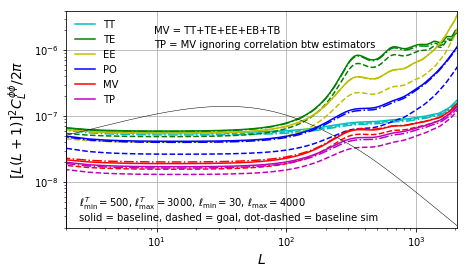

In [5]:
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=2048,xlog=True,ylog=True,ymin=2e-9,ymax=4e-6,grid=True,ylab=r'$[L(L+1)]^2C^{\phi\phi}_L/2\pi$')
for q, c in [('TT','c'),('TE','g'),('EE','y'),('PO','b'),('MV','r'),('TP','m')]:
    for ls, ntype in [('-','baseline'),('--','goal'),('-.','sim')]:
        if ntype == 'baseline': 
            plot(p.quad.eL,al[ntype][q]*2./np.pi,label=q,color=c,ls=ls)
        else:
            plot(p.quad.eL,al[ntype][q]*2./np.pi,color=c,ls=ls)
plot(p.quad.eL,r.kk[:3001]*2./np.pi,'k-',lw=.5)
figtext(.3,.75,r'TP = MV ignoring correlation btw estimators')
figtext(.3,.80,r'MV = TT+TE+EE+EB+TB')
figtext(.15,.15,r'solid = baseline, dashed = goal, dot-dashed = baseline sim')
figtext(.15,.20,r'$\ell^T_{\rm min}='+str(p.lTmin)+r'$, $\ell^T_{\rm max}='+str(p.lTmax)+r'$, $\ell_{\rm min}=30$, $\ell_{\rm max}=4000$')
legend()
savefig('so_noise_kappa.png')

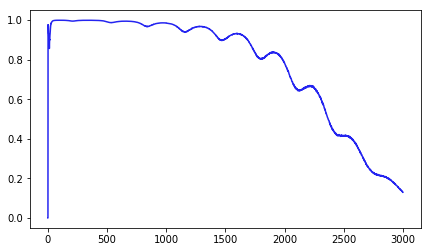

In [6]:
# E diagonal filter
#ocl = prjlib.loadocl(fco.cmb.scl['o'],lTmin=100,lTmax=3000)
nl = np.loadtxt('../../data/sodelens/cmbsims/aps/aps_sim_1d_cocoadd_base_a0.0deg.dat',unpack=True)[10]
WE = r.lee[:p.dlmax+1]/(r.lee[:p.dlmax+1]+nl[:p.dlmax+1]+ep)
plot(WE)

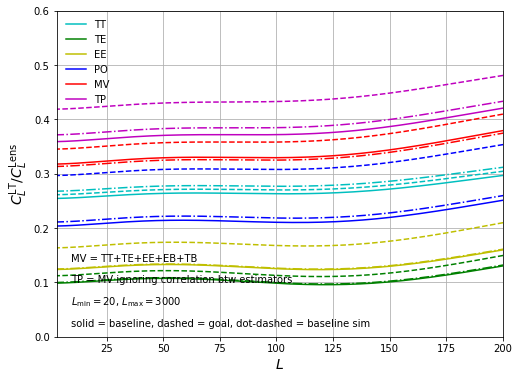

In [7]:
# compute residual BB and template B-mode spectra
pl.plot_1dstyle(fsize=[8,6],xmin=3,xmax=200,ymin=.0,ymax=.6,grid=True,ylab=r'$C_L^{\rm LT}/C_L^{\rm Lens}$')
for ls, ntype in [('-','baseline'),('--','goal'),('-.','sim')]:
    wlk = lens_tools.diag_wiener(p.quad.f,r.kk,p.dlmin,p.dlmax,Al=al[ntype],qlist=['TT','TE','EE','PO','MV','TP'])
    for q, c in [('TT','c'),('TE','g'),('EE','y'),('PO','b'),('MV','r'),('TP','m')]:
        BB = basic.delens.lintemplate(p.lmax,p.dlmin,p.dlmax,r.uee[:p.dlmax+1],r.pp[:p.dlmax+1],WE,wlk[q])
        bb = basic.delens.lensingbb(p.lmax,p.dlmin,p.dlmax,r.uee[:p.dlmax+1],r.pp[:p.dlmax+1])
        if ntype == 'baseline': 
            #plot(BB/(r.lbb+ep),color=c,label=q,ls=ls)
            plot(BB/(bb+ep),color=c,label=q,ls=ls)
        else:
            #plot(BB/(r.lbb+ep),color=c,ls=ls)
            plot(BB/(bb+ep),color=c,ls=ls)
figtext(.15,.25,r'TP = MV ignoring correlation btw estimators')
figtext(.15,.30,r'MV = TT+TE+EE+EB+TB')
figtext(.15,.15,r'solid = baseline, dashed = goal, dot-dashed = baseline sim')
figtext(.15,.20,r'$L_{\rm min}='+str(p.dlmin)+r'$, $L_{\rm max}='+str(p.dlmax)+'$')
legend()
savefig('so_efficiency.png')